## Set up

In [33]:
import os
base_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir) 

In [82]:
# import requests # request img from web
# import shutil # save img locally
# from pathlib import Path
from PIL import Image
# import numpy as np
# import math
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms

In [39]:
import sys
sys.path.append(f'{base_dir}/src/captum')
from captum import optim as optimviz

The tqdm package is required to use captum.optim's n_steps stop criteria with progress bar


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load models

Models: 

https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py

GoogleNet:

https://github.com/pytorch/captum/blob/optim-wip/captum/optim/models/_image/inception_v1.py line 11

torchvision googlenet:

https://github.com/pytorch/vision/blob/main/torchvision/models/googlenet.py

In [20]:
googlenet_torchhub = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
googlenet_torchhub.eval()

Using cache found in /home/lauraom/.cache/torch/hub/pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [28]:
googlenet_torchvision = torchvision.models.googlenet(pretrained=True).to(device)
googlenet_torchvision.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [40]:
googlenet_captum = optimviz.models._image.inception_v1.googlenet(pretrained=True).to(device)
googlenet_captum.eval()

InceptionV1(
  (conv1): Conv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv1_relu): RedirectedReluLayer()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (local_response_norm1): LocalResponseNorm(11, alpha=0.0011, beta=0.5, k=2.0)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2_relu): RedirectedReluLayer()
  (conv3): Conv2dSame(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (conv3_relu): RedirectedReluLayer()
  (local_response_norm2): LocalResponseNorm(11, alpha=0.0011, beta=0.5, k=2.0)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (mixed3a): InceptionModule(
    (conv_1x1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv_3x3_reduce): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
    (conv_3x3_reduce_relu): RedirectedReluLayer()
    (conv_3x3): Conv2dSame(96, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv_5x5_reduce): Conv2d(192, 16, kernel_size=(1, 1), str

## Extract activations

https://discuss.pytorch.org/t/how-to-register-forward-hooks-for-each-module/43347 
https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254

In [46]:
filename = f'{base_dir}/data/test-images/mixed4e55_imagenet/mixed4e55_imagenet_im_0.png'

In [49]:
input_image = Image.open(filename).convert('RGB') # since 'RGBA'
preprocess = transforms.transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [50]:
model = googlenet_torchhub
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

In [51]:
input_batch.shape # torch.Size([1, 3, 224, 224])

torch.Size([1, 3, 224, 224])

### googlenet_torchhub

In [52]:
activation = {}
def get_activation(name):
    def hook(googlenet_torchhub, input, output):
        activation[name] = output.detach()
    return hook

In [53]:
googlenet_torchhub.inception4e.branch1.conv.register_forward_hook(get_activation('inception4e.branch1.conv'))
output = googlenet_torchhub(input_batch)
print(activation['inception4e.branch1.conv'])

tensor([[[[-5.8996e-01, -5.3918e-04,  8.7035e-02,  ..., -4.3434e-01,
            1.5759e-02, -6.0254e-01],
          [-4.7667e-02, -3.7851e-01, -3.6636e-01,  ..., -8.1495e-01,
           -7.7431e-01, -1.2299e+00],
          [ 2.7586e-01, -1.8074e-01, -1.1128e+00,  ..., -8.5017e-01,
           -3.8465e-01, -4.6790e-01],
          ...,
          [-6.8768e-01, -3.8408e-01, -7.8516e-01,  ..., -4.8249e-01,
           -2.8958e-02, -5.3655e-01],
          [-4.8412e-01, -5.7378e-02, -3.4981e-01,  ..., -3.5140e-01,
           -9.2419e-02, -3.7915e-01],
          [-4.4548e-01, -2.0120e-01, -4.0576e-01,  ..., -6.3764e-01,
           -5.5503e-01, -6.8821e-01]],

         [[-5.8648e-01, -4.4707e-01, -4.0711e-01,  ...,  5.2227e-02,
            1.9518e-01, -3.7338e-01],
          [-5.0108e-01, -9.9033e-01, -1.2046e+00,  ..., -3.4684e-01,
           -8.5838e-02, -2.2580e-01],
          [-1.9921e-01, -1.8962e+00, -2.1581e+00,  ..., -1.8155e+00,
           -1.1847e+00, -9.2382e-01],
          ...,
     

In [54]:
print(activation['inception4e.branch1.conv'][0].mean(2).mean(1)[55])
activation['inception4e.branch1.conv'][0].mean(2).mean(1)

tensor(-1.0417)


tensor([-0.6159, -0.5180, -1.4558, -1.1922, -1.4980,  0.2562, -0.5135, -0.4904,
        -0.9703, -0.6608, -1.2949, -0.7500, -1.3681, -0.1363, -1.5643, -0.6122,
        -0.7456, -0.8824, -0.9252, -0.3892, -0.6584, -0.8279, -0.2775, -1.1982,
        -0.8967, -0.9242, -1.0389, -1.1528, -0.6703, -1.0948, -0.9780, -1.0041,
        -0.3507, -0.5458, -1.2385, -0.5098, -0.6917, -0.7085, -0.6416, -0.6745,
        -0.2973, -1.0830, -0.5421, -0.9236, -0.2561, -0.6813, -1.4557, -1.1798,
         0.1050, -1.1631,  0.1403, -1.4496,  0.2195, -0.6628, -0.8256, -1.0417,
        -0.3201, -0.3798, -0.9072, -0.0485, -0.8879,  0.1340, -0.7284, -1.8880,
        -1.0864, -1.1272, -0.3311, -0.8118, -0.8411, -0.6347, -1.2190, -0.6304,
        -0.4716, -0.6883, -0.7384, -1.2185, -0.7271, -1.4821, -0.9260, -1.4130,
        -0.9993, -0.0498, -1.0094, -0.1710, -0.4785, -0.3338, -0.5323, -0.8866,
        -0.2793, -0.9753, -0.4322, -0.7863, -0.9091, -1.4396, -0.1201, -0.3097,
        -1.1748, -0.7898, -1.1169, -0.83

In [55]:
input_batch.shape # torch.Size([1, 3, 224, 224])
activation['inception4e.branch1.conv'].shape # torch.Size([1, 256, 14, 14]) - 256 neurons in layer

torch.Size([1, 256, 14, 14])

### googlenet_torchvision

In [56]:
activation = {}
def get_activation(name):
    def hook(googlenet_torchvision, input, output):
        activation[name] = output.detach()
    return hook

In [57]:
googlenet_torchvision.inception4e.branch1.conv.register_forward_hook(get_activation('inception4e.branch1.conv'))
output = googlenet_torchvision(input_batch)
print(activation['inception4e.branch1.conv'])

tensor([[[[-5.8996e-01, -5.3918e-04,  8.7035e-02,  ..., -4.3434e-01,
            1.5759e-02, -6.0254e-01],
          [-4.7667e-02, -3.7851e-01, -3.6636e-01,  ..., -8.1495e-01,
           -7.7431e-01, -1.2299e+00],
          [ 2.7586e-01, -1.8074e-01, -1.1128e+00,  ..., -8.5017e-01,
           -3.8465e-01, -4.6790e-01],
          ...,
          [-6.8768e-01, -3.8408e-01, -7.8516e-01,  ..., -4.8249e-01,
           -2.8958e-02, -5.3655e-01],
          [-4.8412e-01, -5.7378e-02, -3.4981e-01,  ..., -3.5140e-01,
           -9.2419e-02, -3.7915e-01],
          [-4.4548e-01, -2.0120e-01, -4.0576e-01,  ..., -6.3764e-01,
           -5.5503e-01, -6.8821e-01]],

         [[-5.8648e-01, -4.4707e-01, -4.0711e-01,  ...,  5.2227e-02,
            1.9518e-01, -3.7338e-01],
          [-5.0108e-01, -9.9033e-01, -1.2046e+00,  ..., -3.4684e-01,
           -8.5838e-02, -2.2580e-01],
          [-1.9921e-01, -1.8962e+00, -2.1581e+00,  ..., -1.8155e+00,
           -1.1847e+00, -9.2382e-01],
          ...,
     

In [58]:
print(activation['inception4e.branch1.conv'][0].mean(2).mean(1)[55])
activation['inception4e.branch1.conv'][0].mean(2).mean(1) 

tensor(-1.0417)


tensor([-0.6159, -0.5180, -1.4558, -1.1922, -1.4980,  0.2562, -0.5135, -0.4904,
        -0.9703, -0.6608, -1.2949, -0.7500, -1.3681, -0.1363, -1.5643, -0.6122,
        -0.7456, -0.8824, -0.9252, -0.3892, -0.6584, -0.8279, -0.2775, -1.1982,
        -0.8967, -0.9242, -1.0389, -1.1528, -0.6703, -1.0948, -0.9780, -1.0041,
        -0.3507, -0.5458, -1.2385, -0.5098, -0.6917, -0.7085, -0.6416, -0.6745,
        -0.2973, -1.0830, -0.5421, -0.9236, -0.2561, -0.6813, -1.4557, -1.1798,
         0.1050, -1.1631,  0.1403, -1.4496,  0.2195, -0.6628, -0.8256, -1.0417,
        -0.3201, -0.3798, -0.9072, -0.0485, -0.8879,  0.1340, -0.7284, -1.8880,
        -1.0864, -1.1272, -0.3311, -0.8118, -0.8411, -0.6347, -1.2190, -0.6304,
        -0.4716, -0.6883, -0.7384, -1.2185, -0.7271, -1.4821, -0.9260, -1.4130,
        -0.9993, -0.0498, -1.0094, -0.1710, -0.4785, -0.3338, -0.5323, -0.8866,
        -0.2793, -0.9753, -0.4322, -0.7863, -0.9091, -1.4396, -0.1201, -0.3097,
        -1.1748, -0.7898, -1.1169, -0.83

In [59]:
activation['inception4e.branch1.conv'].shape # torch.Size([1, 256, 14, 14]) - 256 neurons in layer

torch.Size([1, 256, 14, 14])

### googlenet_captum

In [60]:
activation = {}
def get_activation(name):
    def hook(googlenet_captum, input, output):
        activation[name] = output.detach()
    return hook

In [61]:
googlenet_captum.mixed4e.conv_1x1.register_forward_hook(get_activation('mixed4e.conv_1x1'))
output = googlenet_captum(input_batch)
print(activation['mixed4e.conv_1x1'])

/mnt/c/Users/lauraa.omahony/Documents/~PhD_Stuff/1_Workspace/sw-interpretability/src/captum/captum/optim/models/_image/inception_v1.py:209: UserWarning: Model input has values outside of the range [0, 1].
  warn("Model input has values outside of the range [0, 1].")


tensor([[[[-4.5330e+00, -7.4337e+00,  1.7682e+00,  ...,  8.8853e+00,
            1.4699e+01,  1.4988e+01],
          [-1.1282e+01, -1.1512e+01, -6.6918e+00,  ...,  2.4979e+00,
            2.1575e+01,  2.5458e+01],
          [-7.8115e+00, -6.3186e+00, -2.4946e+00,  ..., -9.7630e+00,
            5.6130e+00,  1.2689e+01],
          ...,
          [ 1.4245e+01,  2.5361e+01,  2.4913e+01,  ...,  3.6574e+01,
            2.0892e+01,  5.7895e+00],
          [ 8.8885e+00,  1.6009e+01,  1.7765e+01,  ...,  3.3915e+01,
            1.5632e+01,  6.3883e-01],
          [ 5.3367e+00,  6.1703e+00,  5.6122e+00,  ...,  2.2547e+01,
            6.2093e+00, -3.0197e+00]],

         [[-2.4860e+01, -1.8389e+01, -2.0910e+00,  ..., -2.8058e+00,
            4.5905e+01,  2.8094e+01],
          [-2.6425e+01, -6.9241e+00,  9.8489e+00,  ...,  2.0578e+00,
            3.9507e+01,  3.9089e+01],
          [-2.3425e+01, -2.4052e+00,  1.3045e+01,  ...,  2.8958e+00,
            1.0498e+01,  9.7913e+00],
          ...,
     

In [62]:
print(activation['mixed4e.conv_1x1'][0].mean(2).mean(1)[55])
activation['mixed4e.conv_1x1'][0].mean(2).mean(1)

tensor(51.9002)


tensor([ 2.0670e+01,  2.6568e+00, -9.9606e+00,  1.1299e+01,  1.8719e+01,
        -2.4310e+01,  1.9512e+01, -7.9767e+00, -1.2247e+01, -1.2877e+01,
        -5.3039e+00, -4.2541e+00,  1.8439e+01, -1.0218e+00,  1.7505e+00,
         1.2673e+01, -7.5612e+00, -1.0299e+01, -2.9500e+01, -2.1995e+01,
        -3.3613e-01, -6.9404e+00, -1.6604e+01, -2.6674e+01,  3.0831e+01,
         2.4460e+01, -1.3770e+01,  2.0567e+01, -1.6080e+01, -6.4652e+00,
         6.5528e+00, -7.5050e+00, -2.7825e+01, -3.7578e+00, -1.4884e+01,
         1.2554e+01,  1.3543e+01, -1.5090e+01,  2.8769e+00, -2.0289e+01,
        -1.1649e+01, -2.7810e+00,  1.2036e+02, -4.8256e+00,  1.1198e+00,
        -1.1509e+01, -1.2520e+01, -7.5820e+00,  7.8733e+00, -2.1391e+01,
        -1.2434e+01, -1.4221e+01, -3.3297e+01, -2.8674e+01, -1.0916e+01,
         5.1900e+01, -1.3952e+00, -5.5183e+00, -3.0610e+00, -4.1305e+01,
         3.7013e+01, -1.1625e+01, -4.0018e+00,  1.6728e+00, -9.9210e+00,
        -1.3721e+01,  2.0084e+00,  7.2188e+00, -1.3

In [63]:
input_batch.shape # torch.Size([1, 3, 224, 224])
activation['mixed4e.conv_1x1'].shape # torch.Size([1, 256, 14, 14]) - 256 neurons in layer

torch.Size([1, 256, 14, 14])

### Loop

In [65]:
# activation = {}
def get_activation(name):
    def hook(googlenet_captum, input, output):
        activation[name] = output.detach()
    return hook

In [85]:
activations_cat = torch.empty(0,256,14,14)
activations_car = torch.empty(0,256,14,14)
directory_cat = f'{base_dir}/data/test-images/cat'
directory_car = f'{base_dir}/data/test-images/car'

for file in os.listdir(directory_cat): # os.listdir(directory)
    activation = {}
    input_image = Image.open(directory_cat+'/'+file).convert('RGB') # since 'RGBA'
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    googlenet_captum.mixed4e.conv_1x1.register_forward_hook(get_activation('mixed4e.conv_1x1'))
    output = googlenet_captum(input_batch)
    activations_cat = torch.cat((activations_cat,activation['mixed4e.conv_1x1']))

for file in os.listdir(directory_car):
    activation = {}
    input_image = Image.open(directory_car+'/'+file).convert('RGB') # since 'RGBA'
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    googlenet_captum.mixed4e.conv_1x1.register_forward_hook(get_activation('mixed4e.conv_1x1'))
    output = googlenet_captum(input_batch)
    activations_car = torch.cat((activations_car,activation['mixed4e.conv_1x1']))

/mnt/c/Users/lauraa.omahony/Documents/~PhD_Stuff/1_Workspace/sw-interpretability/src/captum/captum/optim/models/_image/inception_v1.py:209: UserWarning: Model input has values outside of the range [0, 1].
  warn("Model input has values outside of the range [0, 1].")


In [69]:
print(activations_cat[0].mean(2).mean(1)[55])
print(activations_cat[1].mean(2).mean(1)[55])
print(activations_cat[-1].mean(2).mean(1)[55])
activation['mixed4e.conv_1x1'][0].mean(2).mean(1)

tensor(51.9002)
tensor(30.3812)
tensor(36.2447)


tensor([ 5.0376e+00, -4.9111e+00,  1.4150e+01, -1.6354e+00, -2.7737e+00,
        -1.1065e+00, -6.5590e+00, -1.4795e+01, -4.4490e+00,  1.5086e+01,
        -2.0797e+01, -2.0095e+01,  2.7212e+00, -1.3083e+01, -5.1011e+00,
        -1.1686e+01, -9.6292e-01, -7.8750e+00,  4.0149e+00, -1.0331e+01,
         6.7908e+00, -1.1969e+01,  5.1243e+00, -1.3287e+01, -4.5497e+00,
        -1.1915e+01,  1.1651e+01, -6.5405e+00, -4.7897e+00, -2.9820e+00,
        -2.5691e+00,  1.1982e+01, -1.7255e+01, -2.3968e+01, -5.8580e+00,
         1.3675e+01, -1.0549e+01, -7.0029e+00, -4.8587e+00, -1.7680e+01,
         1.9925e+00, -2.3096e+00,  1.2625e+02,  6.6789e+00, -1.3327e-01,
        -5.1863e+00, -5.9694e+00,  6.7918e-01,  7.8991e+00, -8.2906e+00,
        -1.5833e+01,  5.2804e+00, -8.2658e+00, -9.8935e+00, -1.7248e+01,
         2.6972e+01, -4.6030e+00,  9.9497e+00,  6.7233e+00, -1.2542e+01,
         9.7354e+00, -4.4610e+00, -9.8948e+00, -6.8968e+00, -1.3422e+01,
        -4.1376e-03, -1.1488e+01, -6.9146e-01, -2.5

In [71]:
print(activations_car[0].mean(2).mean(1)[55])
# print(mixed4e55_imagenet_activations_car[1].mean(2).mean(1)[55])
print(activations_car[-1].mean(2).mean(1)[55])
activation['mixed4e.conv_1x1'][0].mean(2).mean(1)

tensor(40.8712)
tensor(26.9722)


tensor([ 5.0376e+00, -4.9111e+00,  1.4150e+01, -1.6354e+00, -2.7737e+00,
        -1.1065e+00, -6.5590e+00, -1.4795e+01, -4.4490e+00,  1.5086e+01,
        -2.0797e+01, -2.0095e+01,  2.7212e+00, -1.3083e+01, -5.1011e+00,
        -1.1686e+01, -9.6292e-01, -7.8750e+00,  4.0149e+00, -1.0331e+01,
         6.7908e+00, -1.1969e+01,  5.1243e+00, -1.3287e+01, -4.5497e+00,
        -1.1915e+01,  1.1651e+01, -6.5405e+00, -4.7897e+00, -2.9820e+00,
        -2.5691e+00,  1.1982e+01, -1.7255e+01, -2.3968e+01, -5.8580e+00,
         1.3675e+01, -1.0549e+01, -7.0029e+00, -4.8587e+00, -1.7680e+01,
         1.9925e+00, -2.3096e+00,  1.2625e+02,  6.6789e+00, -1.3327e-01,
        -5.1863e+00, -5.9694e+00,  6.7918e-01,  7.8991e+00, -8.2906e+00,
        -1.5833e+01,  5.2804e+00, -8.2658e+00, -9.8935e+00, -1.7248e+01,
         2.6972e+01, -4.6030e+00,  9.9497e+00,  6.7233e+00, -1.2542e+01,
         9.7354e+00, -4.4610e+00, -9.8948e+00, -6.8968e+00, -1.3422e+01,
        -4.1376e-03, -1.1488e+01, -6.9146e-01, -2.5

Outputs 256 14x14 feature maps. 
How to visualise/analyse this shape? 
Create loop and average?? Look at unit 55. 

In [ ]:
# car hood: imagenet 81, flickr 61, 76, 81, 98

In [72]:
activations_cat_convavg = activations_cat.mean(3).mean(2) 
activations_car_convavg = activations_car.mean(3).mean(2) 

In [78]:
# len(activations_cat_convavg) # 17
# len(activations_car_convavg) # 5
# activations_cat_convavg.shape # torch.Size([17, 256])
# activations_car_convavg.shape # torch.Size([5, 256])

5

## Analyse activations

In [79]:
activations_cat_convavg[0]

tensor([ 2.0670e+01,  2.6568e+00, -9.9606e+00,  1.1299e+01,  1.8719e+01,
        -2.4310e+01,  1.9512e+01, -7.9767e+00, -1.2247e+01, -1.2877e+01,
        -5.3039e+00, -4.2541e+00,  1.8439e+01, -1.0218e+00,  1.7505e+00,
         1.2673e+01, -7.5612e+00, -1.0299e+01, -2.9500e+01, -2.1995e+01,
        -3.3613e-01, -6.9404e+00, -1.6604e+01, -2.6674e+01,  3.0831e+01,
         2.4460e+01, -1.3770e+01,  2.0567e+01, -1.6080e+01, -6.4652e+00,
         6.5528e+00, -7.5050e+00, -2.7825e+01, -3.7578e+00, -1.4884e+01,
         1.2554e+01,  1.3543e+01, -1.5090e+01,  2.8769e+00, -2.0289e+01,
        -1.1649e+01, -2.7810e+00,  1.2036e+02, -4.8256e+00,  1.1198e+00,
        -1.1509e+01, -1.2520e+01, -7.5820e+00,  7.8733e+00, -2.1391e+01,
        -1.2434e+01, -1.4221e+01, -3.3297e+01, -2.8674e+01, -1.0916e+01,
         5.1900e+01, -1.3952e+00, -5.5183e+00, -3.0610e+00, -4.1305e+01,
         3.7013e+01, -1.1625e+01, -4.0018e+00,  1.6728e+00, -9.9210e+00,
        -1.3721e+01,  2.0084e+00,  7.2188e+00, -1.3

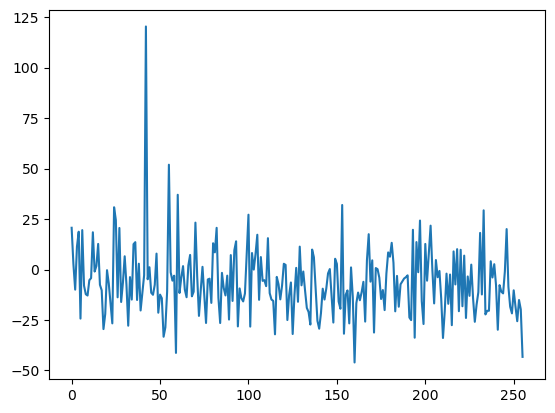

In [83]:
plt.plot(activations_cat_convavg[0]) # 42 peak

In [84]:
activations_car_convavg[2]

tensor([ 2.4143e+00, -8.1993e+00,  1.7875e+01, -1.1238e+01,  8.6440e+00,
         3.6584e+00, -1.0727e+01, -1.2424e+01, -7.2836e+00,  1.2622e+01,
        -2.1161e+01, -8.8233e+00,  3.8180e+00, -1.4443e+01, -5.3038e+00,
        -8.8534e+00, -4.7622e+00, -9.7690e+00, -2.9489e+00, -8.3558e+00,
         9.0305e+00, -1.3737e+01,  1.1373e+00, -1.6018e+01, -7.6267e-01,
        -1.6982e+01,  8.8713e+00, -7.8527e+00, -1.0438e+01, -1.0699e+01,
        -1.9927e+01,  9.7394e+00, -1.5372e+01, -1.1782e+01, -3.0595e+00,
         1.8755e+01, -1.0091e+01, -1.5016e+01, -5.2432e+00, -1.1687e+01,
        -2.8368e+00,  2.0381e+00,  1.1971e+02,  7.3276e+00,  1.5723e+01,
        -1.0064e+01, -1.5567e+01,  2.7730e+00,  2.5680e+01, -7.5134e+00,
        -1.6923e+01,  6.6091e+00, -4.7973e+00, -7.6282e+00, -2.2068e+01,
         2.7765e+01, -3.3257e+00, -3.5991e+00,  7.1929e+00, -1.7320e+01,
         4.1330e+00, -1.6645e+01, -8.3227e+00,  5.7150e+00, -7.4034e+00,
        -1.1748e+00, -6.9157e-01, -3.5383e+00, -5.2

In [ ]:
plt.plot(activations_car_convavg[0]) # 42 peak

Another model...

In [87]:
activations_cat = torch.empty(0,256,14,14)
activations_car = torch.empty(0,256,14,14)
directory_cat = f'{base_dir}/data/test-images/cat'
directory_car = f'{base_dir}/data/test-images/car'

for file in os.listdir(directory_cat): # os.listdir(directory)
    activation = {}
    input_image = Image.open(directory_cat+'/'+file).convert('RGB') # since 'RGBA'
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    googlenet_torchvision.inception4e.branch1.conv.register_forward_hook(get_activation('mixed4e.conv_1x1'))
    output = googlenet_torchvision(input_batch)
    activations_cat = torch.cat((activations_cat,activation['mixed4e.conv_1x1']))

for file in os.listdir(directory_car):
    activation = {}
    input_image = Image.open(directory_car+'/'+file).convert('RGB') # since 'RGBA'
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    googlenet_torchvision.inception4e.branch1.conv.register_forward_hook(get_activation('mixed4e.conv_1x1'))
    output = googlenet_torchvision(input_batch)
    activations_car = torch.cat((activations_car,activation['mixed4e.conv_1x1']))